In [1]:
import pandas as pd
import numpy as np
from pool.error_analysis import ActuatorErrorAnalysis, DebugErrorAnalysis

ea=ActuatorErrorAnalysis()
dea=DebugErrorAnalysis()
data = pd.read_csv('./results/error_data_0.5_degrees.csv', sep=',',decimal='.')
data=data.dropna()     #drop all rows that have any NaN values
data.head()

,real_point_id,C_x,C_y,T_x,T_y,pocket_id,P_x,P_y,deviation_angle,b,...,intercept,slope_X1T,intercept_X1T,slope_X2T,intercept_X2T,X_calculated_x,X_calculated_y,Q_x,Q_y,delta
0,0.0,376.183454,377.619849,781.60902,258.282228,3.0,885.975309,38.392915,0.481067,243.400149,...,456.496118,2.530801,-1719.814787,5.030464,-3673.573652,771.131276,294.809162,849.632254,21.143374,40.228898
1,0.0,376.183454,377.619849,781.60902,258.282228,3.0,885.975309,38.392915,0.047160,243.400149,...,459.475031,2.530801,-1719.814787,5.030464,-3673.573652,765.806065,292.840391,882.841443,36.905485,3.468942
2,0.0,376.183454,377.619849,781.60902,258.282228,3.0,885.975309,38.392915,0.498777,243.400149,...,456.374740,2.530801,-1719.814787,5.030464,-3673.573652,771.390086,294.882411,848.031384,20.383551,42.000935
3,0.0,376.183454,377.619849,781.60902,258.282228,3.0,885.975309,38.392915,-0.069441,243.400149,...,460.277194,2.530801,-1719.814787,5.030464,-3673.573652,764.616068,292.271044,890.476212,40.529183,4.982145
4,0.0,376.183454,377.619849,781.60902,258.282228,3.0,885.975309,38.392915,0.134162,243.400149,...,458.876958,2.530801,-1719.814787,5.030464,-3673.573652,766.748900,293.256174,876.873560,34.072942,10.074919


### Check a specific configuration

Each row of the dataset represents the resut a random shot with an error due to the vision system

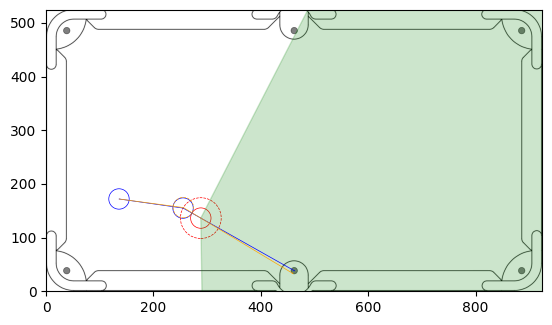

In [2]:
import matplotlib.pyplot as plt

real_point_id=123
idx_of_deviated_config=0 
fig, ax = plt.subplots()
ax.set_xlim((0, dea.pool_table_size[0]))
ax.set_ylim((0, dea.pool_table_size[1]))

sub_data=data[(data['real_point_id']==real_point_id)]
rows=sub_data.to_dict('records')
ax=dea.draw_pool_table_with_pockets(ax)
# we read from first row of sub_data, since the following rows will be the same:
row=rows[idx_of_deviated_config]
ax=dea.draw_ideal_configuration(ax,row)
ax=dea.draw_region_of_interest(ax,row)
ax=dea.draw_real_configuration(ax,row)
ax.plot()  
plt.show()

### Dificulty of the shot

We divide our shots in 3 categories depending on the angle: the closest the angle is to 180 degrees, the better


In [3]:
data['cut_angle']=np.degrees(data['alpha']+data['beta'])
data.loc[(data['cut_angle']<30) & (data['cut_angle']> 0), 'difficulty_category'] = 1
data.loc[(data['cut_angle']<60) & (data['cut_angle']> 30), 'difficulty_category'] = 2
data.loc[(data['cut_angle']<90) & (data['cut_angle']> 60), 'difficulty_category'] = 3

### Visualization of data

Scatter plots of some varaible vs delta

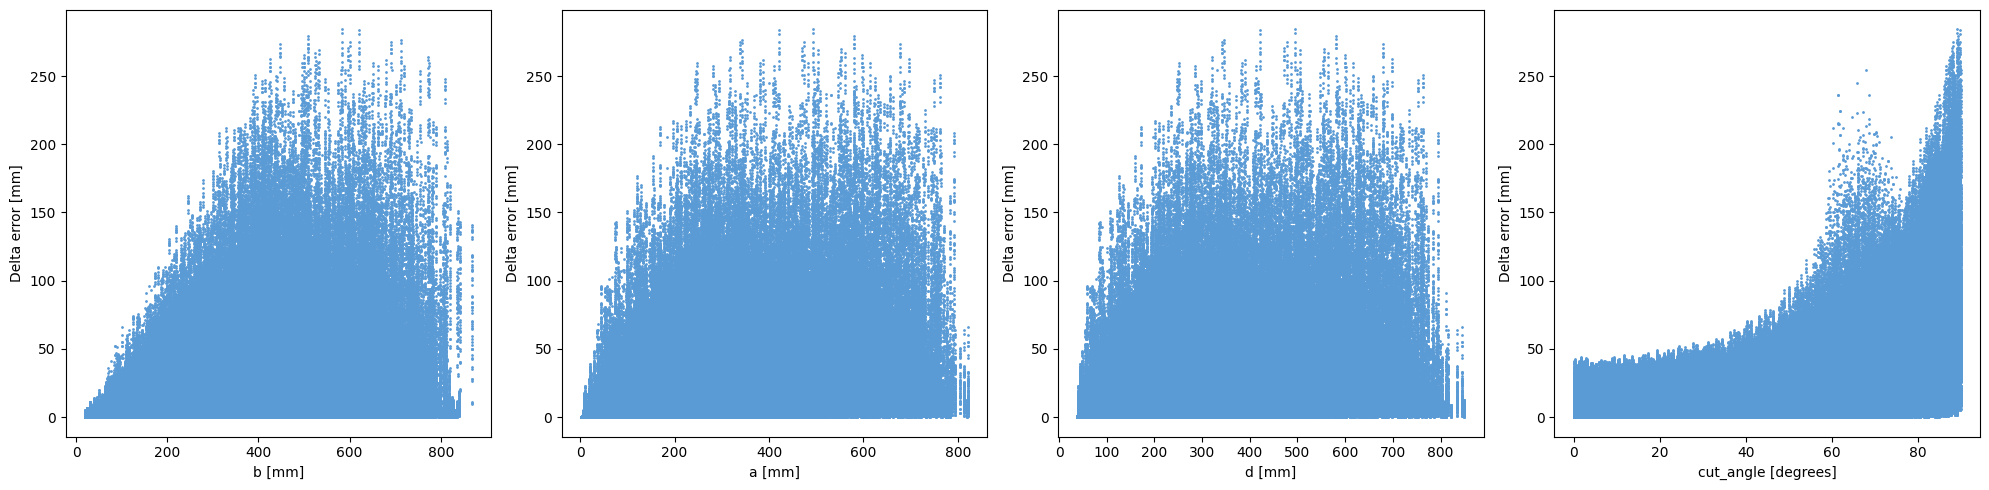

In [4]:
import numpy as np
import matplotlib.pyplot as plt

y = data['delta'].values
x=['b','a','d','cut_angle']
x_label_names=['b [mm]','a [mm]','d [mm]','cut_angle [degrees]']

fig = plt.figure(1,figsize=(20, 5))

columns = 4
rows = 1

for i,col_name,col_label_name in zip(range(1, columns*rows+1),x,x_label_names):

    x=data[col_name].values
    fig.add_subplot(rows, columns, i)
    plt.scatter(x, y, color=(91/255,155/255,213/255), s=1)
    plt.xlabel(col_label_name)
    plt.ylabel('Delta error [mm]')

plt.tight_layout()
plt.show()

Histograms of delta and its categories

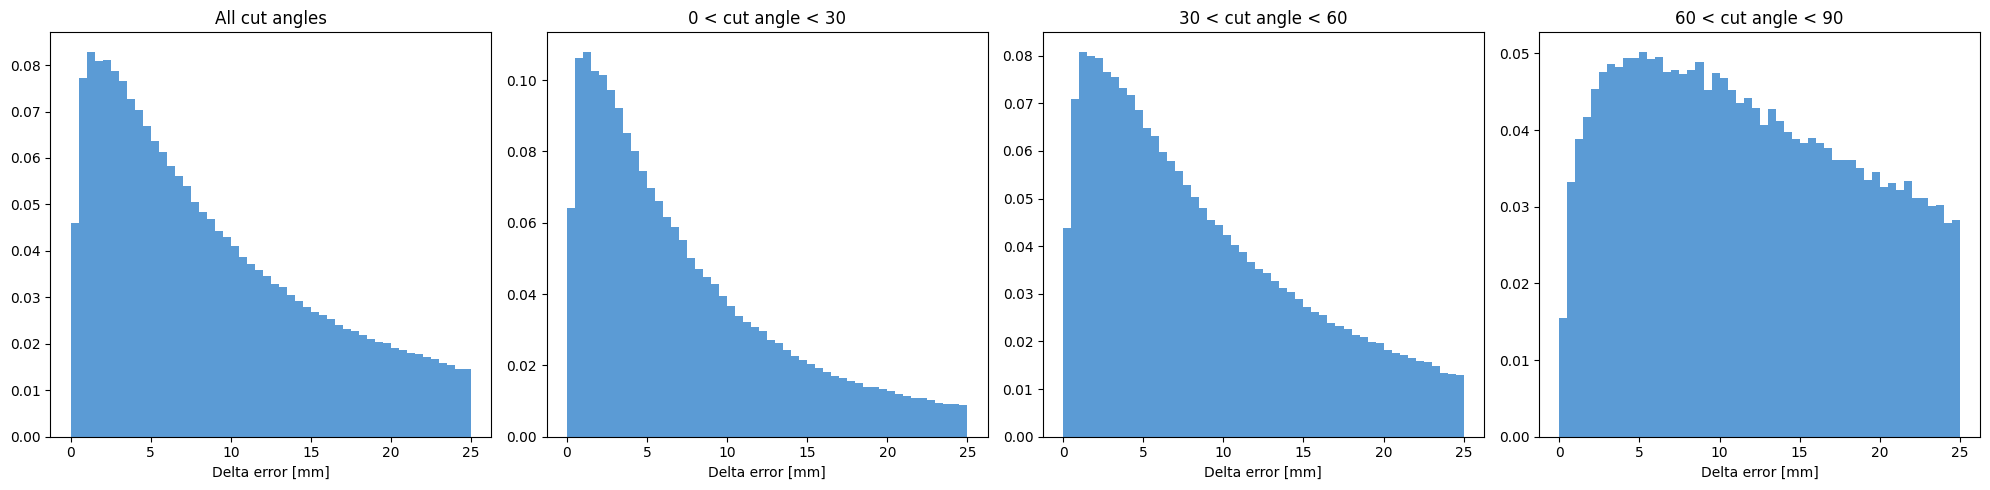

In [5]:
import numpy as np
import matplotlib.pyplot as plt

deltas=data['delta'].values
deltas_category1=data[data['difficulty_category']==1]['delta'].values
deltas_category2=data[data['difficulty_category']==2]['delta'].values
deltas_category3=data[data['difficulty_category']==3]['delta'].values
list_deltas=[deltas,deltas_category1,deltas_category2,deltas_category3]

fig = plt.figure(1,figsize=(20, 5))

columns = 4
rows = 1

for category,i,delta_type in zip(['All cut angles', '0 < cut angle < 30', '30 < cut angle < 60', '60 < cut angle < 90'],range(1, columns*rows+1),list_deltas):

    fig.add_subplot(rows, columns, i)
    plt.title(category)
    plt.hist(delta_type, bins=50 ,range=[0, 25], density=True, color=(91/255,155/255,213/255))
    plt.xlabel('Delta error [mm]')


plt.tight_layout()
plt.show()


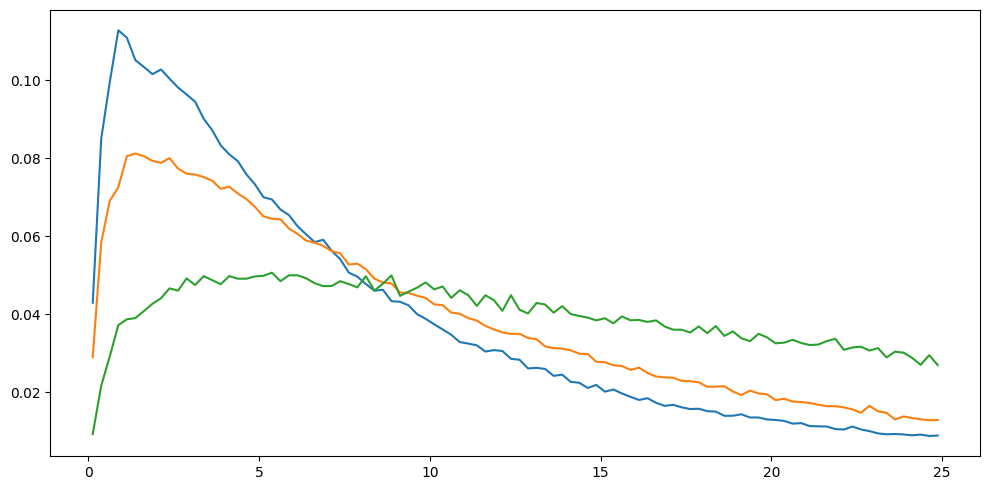

In [6]:
fig = plt.figure(1,figsize=(10, 5))

n,x=np.histogram(deltas_category1, bins = 100,range=[0, 25],density=True)
bin_centers = 0.5*(x[1:]+x[:-1])
plt.plot(bin_centers,n) ## using bin_centers rather than edges

n,x=np.histogram(deltas_category2, bins = 100,range=[0, 25],density=True)
bin_centers = 0.5*(x[1:]+x[:-1])
plt.plot(bin_centers,n) ## using bin_centers rather than edges

n,x=np.histogram(deltas_category3, bins = 100,range=[0, 25],density=True)
bin_centers = 0.5*(x[1:]+x[:-1])
plt.plot(bin_centers,n) ## using bin_centers rather than edges

plt.tight_layout()
plt.show()


### Probability of getting an error below a certain threshold

probability of error below 10mm:  0.6264936407030792


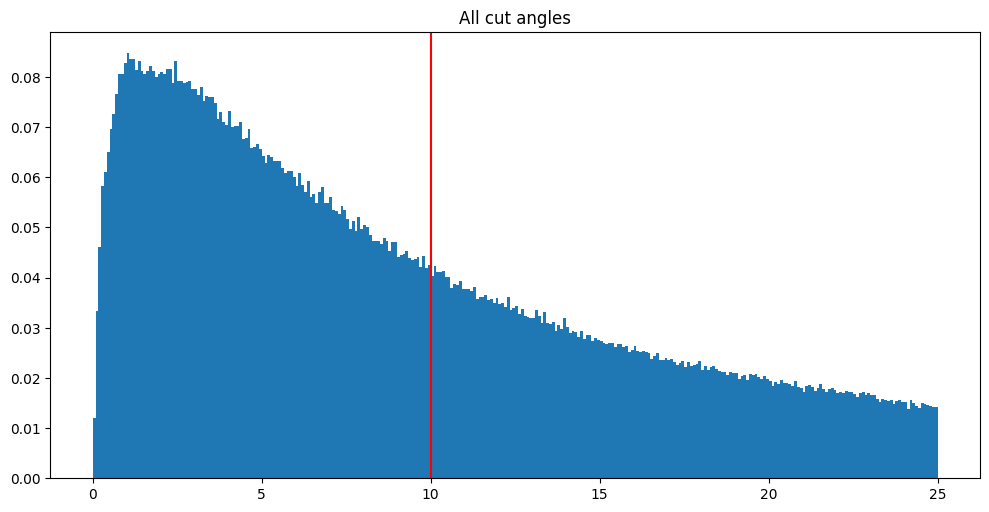

probability of error below 10mm:  0.7202134719610663


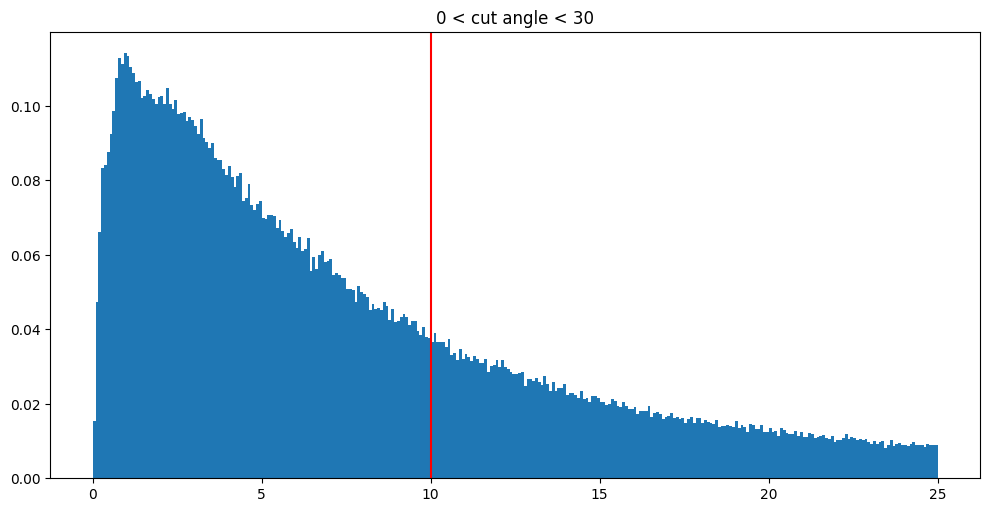

probability of error below 10mm:  0.6278251680066327


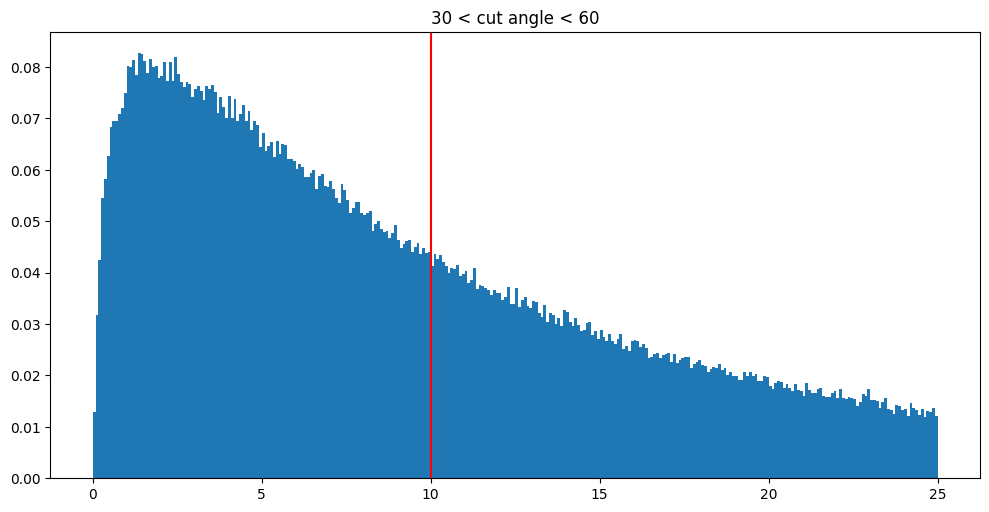

probability of error below 10mm:  0.4456506860133307


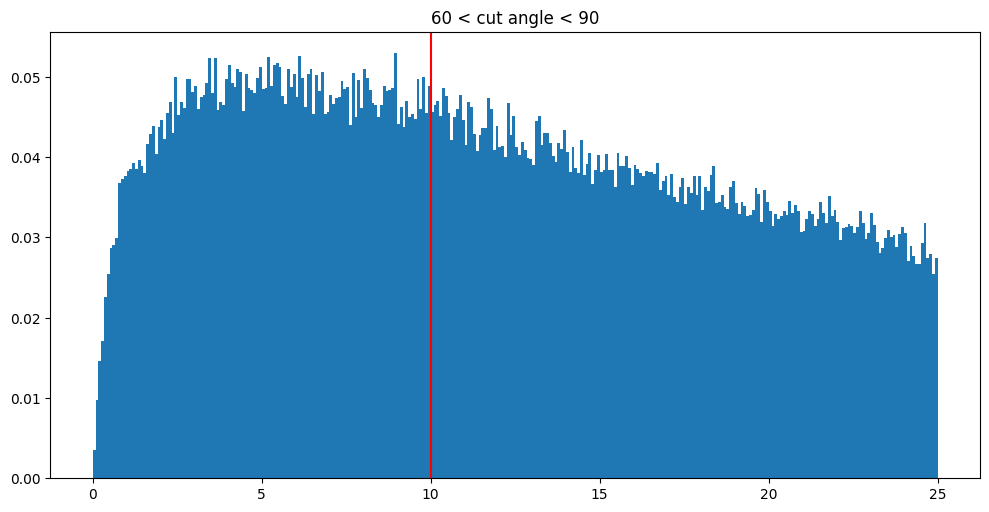

In [7]:
threshold=10
num_bins=300

for category,deltas_category in zip(['All cut angles', '0 < cut angle < 30', '30 < cut angle < 60', '60 < cut angle < 90'], [deltas,deltas_category1,deltas_category2,deltas_category3]):
    arr_pdf,arr_bins=np.histogram(deltas_category, bins = num_bins,range=[0, 25],density=True)

    #in order to match dimensions of bins and pdf arrays we get rid of last bins element
    arr_bins_cropped=arr_bins[:-1]
    arr_bins_thresholded=arr_bins_cropped[arr_bins_cropped<threshold]

    #in order to have the same dimension between _pdf and np.diff(_bins), _bins need to have one 
    #more element than _pdf (i.e., _pdf need to have one less element than _bins)
    arr_pdf_thresholded=arr_pdf[arr_bins_cropped<threshold][:-1]
    area=np.sum(arr_pdf_thresholded* np.diff(arr_bins_thresholded))
    print(f'probability of error below {threshold}mm: ', area)

    #plot computed probability
    fig = plt.figure(1,figsize=(10, 5))
    plt.hist(deltas_category, bins = num_bins, range=[0, 25],density=True)
    plt.axvline(x=threshold, color='r')
    plt.tight_layout()
    plt.title(f'{category}')
    plt.show()
